# Applied Machine Learning Lab 3: Fashion MNIST

This notebook was written by Jiayi Zhu. It explores the performance of different types of classifier algorithms using the Fashion MNIST dataset.


In [30]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


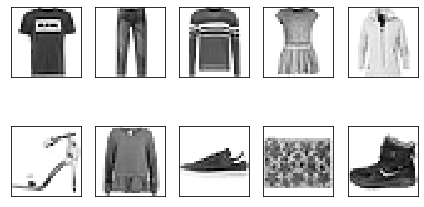

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = x_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [32]:
x_train = x_train.reshape(x_train.shape[0], (x_train.shape[1]*x_train.shape[2]))
x_test = x_test.reshape(x_test.shape[0], (x_test.shape[1]*x_test.shape[2]))
print(x_train.shape)


(60000, 784)


In [33]:
# only using half the dataset to reduce computation time

x_train = x_train[:30000]
y_train = y_train[:30000]
x_test = x_test[:5000]
y_test = y_test[:5000]

In [34]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
import seaborn as sns

### Stochasitc Gradient Descent Classifier

In [35]:
sgd = SGDClassifier(random_state=50)
cv = KFold(n_splits=5, random_state=None)

n_scores = cross_val_score(sgd, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Accuracy: 0.792 (0.017)


<Figure size 4000x2000 with 0 Axes>

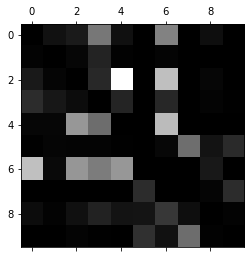

In [36]:
# confusion matrix
y_train_pred = cross_val_predict(sgd, x_train, y_train, cv=cv)
conf_mx = confusion_matrix(y_train, y_train_pred)

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums # to normalize the matrix
np.fill_diagonal(norm_conf_mx, 0) # to see only errors

figure(num=None, figsize=(20, 10), dpi=200, facecolor='w', edgecolor='k')
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

The confusion matrix gives us a better idea of what mistakes the algorithm is making. We see that lighter squares indicate larger errors. For example, it seems shirts, pullovers, and coats (2, 4, and 6) are often mistaken for one another. This is understandable because if you look at the images of these three articles of clothing, they do look very similar in shape. 

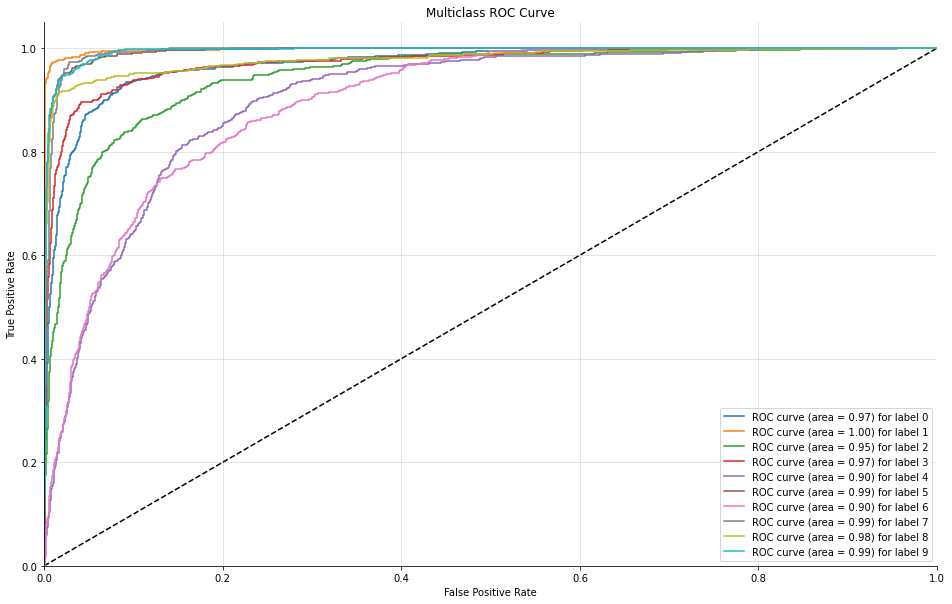

In [37]:
# function for multiclass roc plotting adjusted from https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification
def plot_multiclass_roc(clf, x_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(x_test)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Multiclass ROC Curve')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    
sgd.fit(x_train, y_train)
plot_multiclass_roc(sgd, x_test, y_test, n_classes=10, figsize=(16, 10))

**Key**
- 0 - T-shirt/top
- 1 - Trouser
- 2 - Pullover
- 3 - Dress
- 4 - Coat
- 5 - Sandal
- 6 - Shirt
- 7 - Sneaker
- 8 - Bag
- 9 - Ankle boot

## Random Forest Classifier

In [38]:
forest = RandomForestClassifier(random_state=50)
cv = KFold(n_splits=5, random_state=None)

n_scores = cross_val_score(forest, x_train,
                                    y_train, scoring='accuracy', cv=cv,
                                    n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.872 (0.004)


In [39]:
# hyperparameter tuning with GridSearchCV

x_train_smaller = x_train[:7500] # using even smaller dataset to reduce computation time
y_train_smaller = y_train[:7500]
x_test_smaller = x_test[:1250]
y_test_smaller = y_test[:1250]

param_grid = [{'n_estimators': [75, 100, 125], 'max_depth': [20, 25, 30], 'max_features': [25, 50, 75]}]

grid_search = GridSearchCV(forest, param_grid, cv=cv,
                           scoring='accuracy', n_jobs=-1, error_score='raise',
                           return_train_score=True)

grid_search.fit(x_train_smaller, y_train_smaller)
grid_search.best_estimator_

RandomForestClassifier(max_depth=25, max_features=75, n_estimators=125,
                       random_state=50)

Using a random forest classifier (default params) and cross validation with 5 splits, the average accuracy for the estimator on each run is 87.2%. I used Grid Search to try some different parameters and it would seem max_depth of 25 is optimal whereas n_estimators and max_features can probably be scaled up further to get even better results.

## K Nearest Neighbors Classifier

In [40]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(x_train_smaller, y_train_smaller)  #using even smaller dataset so kernal doesn't die
y_pred = knn.predict(x_test_smaller)
print('Accuracy:', accuracy_score(y_test_smaller, y_pred))

Accuracy: 0.8224


## One vs One Classifier

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
ovo = OneVsOneClassifier(LinearSVC(random_state=50)) # linearsvc param?
ovo.fit(x_train, y_train)
y_pred = ovo.predict(x_test)
print('Accuracy', accuracy_score(y_test, y_pred))

Accuracy 0.7878


## Ensemble of Methods

In [43]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
bagging.fit(x_train_smaller, y_train_smaller)
y_pred = bagging.predict(x_test_smaller)
print('Accuracy:', accuracy_score(y_test_smaller, y_pred))

Accuracy: 0.8152
